In [197]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [198]:
from luxai_s3.wrappers import LuxAIS3GymEnv

env = LuxAIS3GymEnv(numpy_output=True)

obs, info = env.reset(seed=42)

In [199]:
info['full_params']

{'max_steps_in_match': 100,
 'map_type': 1,
 'map_width': 24,
 'map_height': 24,
 'num_teams': 2,
 'match_count_per_episode': 5,
 'max_units': 16,
 'init_unit_energy': 100,
 'min_unit_energy': 0,
 'max_unit_energy': 400,
 'unit_move_cost': 2,
 'spawn_rate': 3,
 'unit_sap_cost': 49,
 'unit_sap_range': 6,
 'unit_sap_dropoff_factor': 1.0,
 'unit_energy_void_factor': 0.25,
 'max_energy_nodes': 6,
 'max_energy_per_tile': 20,
 'min_energy_per_tile': -20,
 'max_relic_nodes': 6,
 'relic_config_size': 5,
 'fog_of_war': True,
 'unit_sensor_range': 2,
 'nebula_tile_vision_reduction': 1,
 'nebula_tile_energy_reduction': 10,
 'nebula_tile_drift_speed': -0.02500000037252903,
 'energy_node_drift_speed': 0.05000000074505806,
 'energy_node_drift_magnitude': 4}

# Default Kit Agent

In [208]:
import numpy as np

 #   direction (0 = center, 1 = up, 2 = right, 3 = down, 4 = left)
def direction_to(src, target):
    ds = target - src
    dx = ds[0]
    dy = ds[1]
    if dx == 0 and dy == 0:
        return 0
    if abs(dx) > abs(dy):
        if dx > 0:
            return 2 
        else:
            return 4
    else:
        if dy > 0:
            return 3
        else:
            return 1


class Agent():
    def __init__(self, player: str, env_cfg) -> None:
        self.player = player
        self.opp_player = "player_1" if self.player == "player_0" else "player_0"
        self.team_id = 0 if self.player == "player_0" else 1
        self.opp_team_id = 1 if self.team_id == 0 else 0
        np.random.seed(0)
        self.env_cfg = env_cfg
        
        self.relic_node_positions = []
        self.discovered_relic_nodes_ids = set()
        self.unit_explore_locations = dict()

    def act(self, step: int, obs, remainingOverageTime: int = 60):
        """implement this function to decide what actions to send to each available unit. 
        
        step is the current timestep number of the game starting from 0 going up to max_steps_in_match * match_count_per_episode - 1.
        """
        unit_mask = np.array(obs["units_mask"][self.team_id]) # shape (max_units, )
        unit_positions = np.array(obs["units"]["position"][self.team_id]) # shape (max_units, 2)
        unit_energys = np.array(obs["units"]["energy"][self.team_id]) # shape (max_units, 1)
        observed_relic_node_positions = np.array(obs["relic_nodes"]) # shape (max_relic_nodes, 2)
        observed_relic_nodes_mask = np.array(obs["relic_nodes_mask"]) # shape (max_relic_nodes, )
        team_points = np.array(obs["team_points"]) # points of each team, team_points[self.team_id] is the points of the your team
        
        # ids of units you can control at this timestep
        available_unit_ids = np.where(unit_mask)[0]
        # visible relic nodes
        visible_relic_node_ids = set(np.where(observed_relic_nodes_mask)[0])
        
        actions = np.zeros((self.env_cfg["max_units"], 3), dtype=int)


        # basic strategy here is simply to have some units randomly explore and some units collecting as much energy as possible
        # and once a relic node is found, we send all units to move randomly around the first relic node to gain points
        # and information about where relic nodes are found are saved for the next match
        
        # save any new relic nodes that we discover for the rest of the game.
        for id in visible_relic_node_ids:
            if id not in self.discovered_relic_nodes_ids:
                self.discovered_relic_nodes_ids.add(id)
                self.relic_node_positions.append(observed_relic_node_positions[id])
            

        # unit ids range from 0 to max_units - 1
        for unit_id in available_unit_ids:
            unit_pos = unit_positions[unit_id]
            unit_energy = unit_energys[unit_id]
            if len(self.relic_node_positions) > 0:
                nearest_relic_node_position = self.relic_node_positions[0]
                manhattan_distance = abs(unit_pos[0] - nearest_relic_node_position[0]) + abs(unit_pos[1] - nearest_relic_node_position[1])
                
                # if close to the relic node we want to hover around it and hope to gain points
                if manhattan_distance <= 4:
                    random_direction = np.random.randint(0, 5)
                    actions[unit_id] = [random_direction, 0, 0]
                else:
                    # otherwise we want to move towards the relic node
                    actions[unit_id] = [direction_to(unit_pos, nearest_relic_node_position), 0, 0]
            else:
                # randomly explore by picking a random location on the map and moving there for about 20 steps
                if step % 20 == 0 or unit_id not in self.unit_explore_locations:
                    rand_loc = (np.random.randint(0, self.env_cfg["map_width"]), np.random.randint(0, self.env_cfg["map_height"]))
                    self.unit_explore_locations[unit_id] = rand_loc
                actions[unit_id] = [direction_to(unit_pos, self.unit_explore_locations[unit_id]), 0, 0]
        return actions


# random runs for some steps

In [478]:
PLAYER0 = 'player_0'
PLAYER1 = 'player_1'

MAX_MATCH_STEP = 100
MAX_UNIT_NUM = 16

MAP_WIDTH = 24
MAP_HEIGHT = 24

CELL_UNKONWN = 0
CELL_SPACE = 1
CELL_NEBULA = 2
CELL_ASTERIOD = 3

RELIC_NB_SIZE = 5

TEAM_POINT_MASS = 100
NON_TEAM_POINT_MASS = -100

MAX_GAME_STEPS = 505
MAX_MATCH_STEPS = 100

# 0 is do nothing, 1 is move up, 2 is move right, 3 is move down, 4 is move left, 5 is sap
MOVE_ACTION_NUM = 5


In [488]:
from luxai_s3.wrappers import LuxAIS3GymEnv, RecordEpisode


from scipy.ndimage import maximum_filter


def anti_diag_sym(A):
    A = np.flipud(A) 
    A = np.fliplr(A)
    A = A.T
    return A

class MapManager:

    def __init__(self, player, env_cfg):
        self.player_id = int(player[-1])
        self.env_cfg = env_cfg
        self.cell_type = np.zeros((MAP_WIDTH, MAP_HEIGHT), np.int32)
        self.visible = None
        self.observed = np.zeros((MAP_WIDTH, MAP_HEIGHT), np.int32)
        self.visited = np.zeros((MAP_WIDTH, MAP_HEIGHT), np.int32)
        self.is_relic_node = np.zeros((MAP_WIDTH, MAP_HEIGHT), np.int32)
        self.is_relic_neighbour = np.zeros((MAP_WIDTH, MAP_HEIGHT), np.int32)

        self.prev_team_point = 0
        self.team_point_mass = np.ones((MAP_WIDTH, MAP_HEIGHT), np.float32)
    
    def update(self, ob):
        # Match restarted
        if ob['match_steps'] == 0:
            self.prev_team_point = 0
 
        self.visible = ob['sensor_mask'].astype(np.int32)
        self.observed |= self.visible

        # adding 1 to start cell type from 0
        cells = ob['map_features']['tile_type'] + 1

        # Update map cell type
        c = cells > CELL_UNKONWN
        self.cell_type[c] = cells[c]

        # also update the symmetrical positions
        cells_sym = anti_diag_sym(cells)
        ct = cells_sym > CELL_UNKONWN
        self.cell_type[ct] = cells_sym[ct]

        unit_masks = ob['units_mask'][self.player_id]
        unit_positions = ob['units']['position'][self.player_id][unit_masks]
        self.visited[unit_positions[:, 0], unit_positions[:, 1]] = 1

        relic_nodes_mask = ob['relic_nodes_mask']
        relic_nodes_positions = ob['relic_nodes'][relic_nodes_mask]
        self.is_relic_node[relic_nodes_positions[:, 0], relic_nodes_positions[:, 1]] = 1
        self.is_relic_node |= anti_diag_sym(self.is_relic_node)
        self.is_relic_neighbour = maximum_filter((self.is_relic_node == 1).astype(np.int32), size=RELIC_NB_SIZE)

        self.update_team_point_mass(ob, unit_positions)
        self.prev_team_point = team_point

    def update_team_point_mass(self, ob, unit_positions):
        # Update team point confidence
        team_point = ob['team_points'][self.player_id]
        # print(ob['steps'], ob['match_steps'], 'team_point=', team_point, 'prev_point', self.prev_team_point)
        if 0 < ob['match_steps'] and len(unit_positions):
            unit_pos_mask = np.zeros((MAP_WIDTH, MAP_HEIGHT), dtype=bool)
            unit_pos_mask[unit_positions[:, 0], unit_positions[:, 1]] = True            
            unit_nearby_relic = (self.is_relic_neighbour > 0) & (unit_pos_mask)
            if unit_nearby_relic.sum() > 0:            
                must_be_team_point = (self.team_point_mass >= TEAM_POINT_MASS) & (unit_nearby_relic)
                non_team_point = (self.team_point_mass <= NON_TEAM_POINT_MASS) & (unit_nearby_relic)

                delta = team_point - self.prev_team_point
                delta -= must_be_team_point.sum()

                team_point_candidate = unit_nearby_relic & (~must_be_team_point) & (~non_team_point)
                num = team_point_candidate.sum()
                if num > 0:
                    if delta == 0:
                        self.team_point_mass[team_point_candidate] = NON_TEAM_POINT_MASS
                        self.team_point_mass[anti_diag_sym(team_point_candidate)] = NON_TEAM_POINT_MASS
                    elif num == delta:
                        self.team_point_mass[team_point_candidate] = TEAM_POINT_MASS
                        self.team_point_mass[anti_diag_sym(team_point_candidate)] = TEAM_POINT_MASS
                    else:
                        assert delta < num
                        # print('>>>>>>>>>>>>>>', ob['steps'], delta, num, must_be_team_point.sum(), non_team_point.sum())
                        self.team_point_mass[anti_diag_sym(team_point_candidate)] += delta / num
                    assert delta >= 0

        
env = LuxAIS3GymEnv(numpy_output=True)
env = RecordEpisode(env, save_dir="episodes")
obs, info = env.reset(seed=42)

env_cfg = info['params']
a0 = Agent('player_0', env_cfg)
a1 = Agent('player_1', env_cfg)


def act(a, obs):
    player_id = a.player
    step = obs[player_id]['steps']
    ob = obs[player_id]
    actions = a.act(step, ob)
    return actions

mm = MapManager(PLAYER0, env_cfg)
for i in range(400):
    mm.update(obs[PLAYER0])
    
    action0 = act(a0, obs)
    action1 = act(a1, obs)
    player_actions = {PLAYER0: action0, PLAYER1: action1}
    obs, reward, terminated, truncated, info = env.step(player_actions)

env.close()

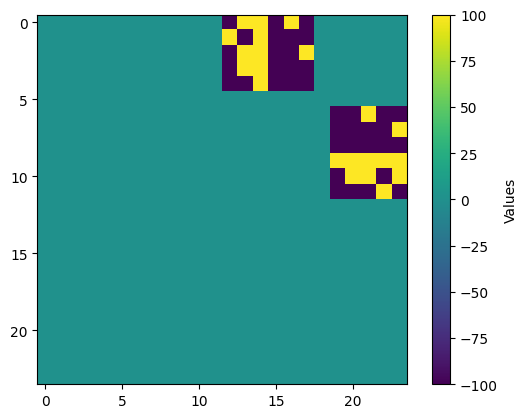

In [489]:
# plt.imshow(mm.visible, cmap='viridis', interpolation='none')
# plt.imshow(mm.observed, cmap='viridis', interpolation='none')

# plt.imshow(mm.cell_type, cmap='viridis', interpolation='none')

# plt.imshow(mm.is_relic_neighbour, cmap='viridis', interpolation='none')
# plt.imshow(mm.is_relic_node, cmap='viridis', interpolation='none')

plt.imshow(mm.team_point_mass.astype(int).T, cmap='viridis', interpolation='none')
plt.colorbar(label="Values")

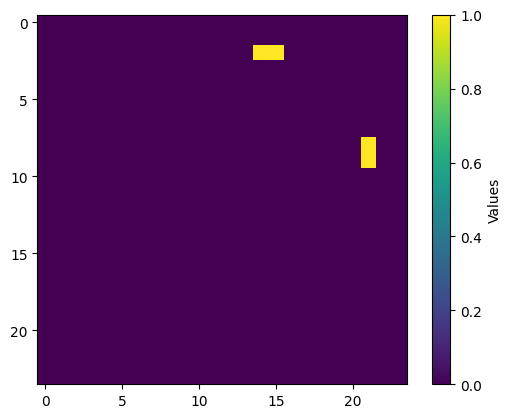

In [490]:
plt.imshow(mm.is_relic_node.T, cmap='viridis', interpolation='none')
plt.colorbar(label="Values")

In [355]:
o = obs[PLAYER0]

o['relic_nodes_mask'], o['relic_nodes'][o['relic_nodes_mask']]

(array([ True,  True, False, False, False, False]),
 array([[14,  2],
        [15,  2]], dtype=int16))

In [388]:
o['team_points'][0]

np.int32(43)

In [390]:
target_matrix = np.zeros((5, 5), dtype=int)

# Example indices (n x 2 array where each row is an (x, y) pair)
indices = np.array([[0, 1],
                    [2, 3],
                    [4, 4],
                    [1, 0]])

# Example values to update at the given indices
values = np.array([10, 20, 30, 40])

# Split the indices into row and column arrays
x, y = indices[:, 0], indices[:, 1]
target_matrix[x, y] = values


In [392]:
target_matrix[x, y]

array([10, 20, 30, 40])

In [394]:
target_matrix[target_matrix > 0]

array([10, 40, 20, 30])

# Steps and Match

In [204]:
obs['player_0'].keys()

dict_keys(['units', 'units_mask', 'sensor_mask', 'map_features', 'relic_nodes', 'relic_nodes_mask', 'team_points', 'team_wins', 'steps', 'match_steps'])

In [205]:
player_0 = obs['player_0']

In [206]:
for i in range(30):
    obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
    player_0 = obs['player_0']
    print(terminated, player_0['steps'], player_0['match_steps'], player_0['team_wins'])

{'player_0': array(False), 'player_1': array(False)} 81 81 [0 0]
{'player_0': array(False), 'player_1': array(False)} 82 82 [0 0]
{'player_0': array(False), 'player_1': array(False)} 83 83 [0 0]
{'player_0': array(False), 'player_1': array(False)} 84 84 [0 0]
{'player_0': array(False), 'player_1': array(False)} 85 85 [0 0]
{'player_0': array(False), 'player_1': array(False)} 86 86 [0 0]
{'player_0': array(False), 'player_1': array(False)} 87 87 [0 0]
{'player_0': array(False), 'player_1': array(False)} 88 88 [0 0]
{'player_0': array(False), 'player_1': array(False)} 89 89 [0 0]
{'player_0': array(False), 'player_1': array(False)} 90 90 [0 0]
{'player_0': array(False), 'player_1': array(False)} 91 91 [0 0]
{'player_0': array(False), 'player_1': array(False)} 92 92 [0 0]
{'player_0': array(False), 'player_1': array(False)} 93 93 [0 0]
{'player_0': array(False), 'player_1': array(False)} 94 94 [0 0]
{'player_0': array(False), 'player_1': array(False)} 95 95 [0 0]
{'player_0': array(False)